# Imports and utility

In [1]:
#d8f53b61969adf7ee621c216f680b707
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import keras_hub
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout,
                                     BatchNormalization, Activation, GlobalAveragePooling2D)
from tensorflow.keras.applications import VGG16, VGG19, ResNet50, ResNet152, EfficientNetB0, DenseNet121, InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras import optimizers

train_dir = '/kaggle/input/knee-osteoarthritis-dataset-with-severity/train'
val_dir = '/kaggle/input/knee-osteoarthritis-dataset-with-severity/val'
test_dir = '/kaggle/input/knee-osteoarthritis-dataset-with-severity/test'
auto_test = '/kaggle/input/knee-osteoarthritis-dataset-with-severity/auto_test'
cat_dir = '/kaggle/input/cat-knee/clean'

IMG_SIZE = (224, 224)
BATCH_SIZE = 8
SEED = 66


In [2]:
import pandas as pd
import os

def create_dataframe_from_directory(base_dir, regression=False):
    data = []
    for label_str in sorted(os.listdir(base_dir)):
        label_path = os.path.join(base_dir, label_str)
        if not os.path.isdir(label_path):
            continue
        label = float(label_str) if regression else label_str
        for fname in os.listdir(label_path):
            data.append({
                'filename': os.path.join(label_str, fname),  # ruta relativa
                'label': label  # KL debe ser numérico para regresión
            })
    return pd.DataFrame(data)

In [3]:
from sklearn.metrics import mean_absolute_error, accuracy_score
import numpy as np
import tensorflow as tf

class CatValidationCallback(tf.keras.callbacks.Callback):
    def __init__(self, cat_generator, regresion=False, filepath='best_model_cat.keras'):
        super().__init__()
        self.cat_generator = cat_generator
        self.epoch_metrics = []
        self.regresion = regresion
        self.filepath = filepath
        # Inicializamos best_score y best_loss
        if regresion:
            self.best_score = 0.0    # queremos maximizar accuracy
            self.best_loss  = np.inf # y minimizar MAE
        else:
            self.best_score = 0.0    # queremos maximizar accuracy
            self.best_loss  = np.inf # y minimizar categorical loss

    def on_epoch_end(self, epoch, logs=None):
        # Predicciones
        preds = self.model.predict(self.cat_generator, verbose=0)

        if self.regresion:
            # Regresión: calculamos MAE + accuracy sobre clases redondeadas
            y_pred = preds.flatten()
            y_true = self.cat_generator.labels
            loss = mean_absolute_error(y_true, y_pred)
            y_pred_class = np.clip(np.round(y_pred), 0, 4).astype(int)
            y_true_class = np.clip(np.round(y_true), 0, 4).astype(int)
            acc = accuracy_score(y_true_class, y_pred_class)
            score = acc
        else:
            # Clasificación: evalúa el loss y la accuracy
            loss, acc = self.model.evaluate(self.cat_generator, verbose=0)
            preds_class = np.argmax(preds, axis=1)
            y_true = self.cat_generator.classes
            # para consistency, recalculamos acc con sklearn
            acc = accuracy_score(y_true, preds_class)
            score = acc

        # Guardar métricas
        self.epoch_metrics.append({
            'epoch': epoch + 1,
            'val_cat_loss': loss,
            'val_cat_accuracy': acc
        })

        # Mostrar por consola
        tag = "MAE" if self.regresion else "Loss"
        print(f"🐾 [Cat Val] {tag}: {loss:.4f} | Accuracy: {acc:.4f}")

        # Comprobamos mejora: primero por score, si empate por loss
        improved = False
        if score > self.best_score:
            improved = True
        elif score == self.best_score and loss < self.best_loss:
            improved = True

        # Si mejoró, guardamos modelo y actualizamos referencias
        if improved:
            self.best_score = score
            self.best_loss  = loss
            self.model.save(self.filepath)
            print(f"📦 Modelo mejorado guardado en {self.filepath}")


In [4]:
from tensorflow.keras.callbacks import ModelCheckpoint

def get_callbacks(regression=False, cat_gen=None):
  cat_val_cb = CatValidationCallback(cat_gen, regresion=regression)
  

  checkpoint_cb = ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_accuracy',         # nombre de la métrica a monitorizar
    mode='max',                     # porque buscamos la mayor precisión
    save_best_only=True,
    save_weights_only=False,
    verbose=1
  )
  checkpoint_cb_reg = ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
  )
  if regression:
    callbacks = [
        EarlyStopping(patience=10, restore_best_weights=True),
        ReduceLROnPlateau(factor=0.5, patience=5, verbose=1),
        cat_val_cb,
        checkpoint_cb_reg
    ]
  else:
    callbacks = [
        EarlyStopping(patience=10, restore_best_weights=True),
        ReduceLROnPlateau(factor=0.5, patience=5, verbose=1),
        cat_val_cb,
        checkpoint_cb
    ]
  return callbacks


In [5]:
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import cv2
from tensorflow.keras.layers import Conv2D
import tensorflow as tf
from tensorflow.keras import backend as K

def _get_label_map(y_true, y_pred, generator=None, default_prefix='KL'):
    """
    Genera label_map automáticamente.
    - Si el generador tiene class_indices (clasificación Keras), los usa.
    - Si no, extrae las clases únicas de y_true y y_pred.
    - Si todo falla, crea labels 'KL 0', 'KL 1', ..., según número de clases.
    """
    if generator is not None and hasattr(generator, 'class_indices'):
        sorted_items = sorted(generator.class_indices.items(), key=lambda x: x[1])
        return [name for name, _ in sorted_items]
    classes = np.unique(np.concatenate((y_true, y_pred)))
    if np.array_equal(classes, np.arange(len(classes))):
        return [f'{default_prefix} {i}' for i in classes]
    return [str(c) for c in classes]

def overlay_heatmap(heatmap, img, alpha=0.4, colormap=cv2.COLORMAP_JET):
    """
    Superpone el heatmap sobre la imagen original.
    """
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, colormap)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    superimposed = heatmap * alpha + img
    return superimposed / superimposed.max()

def find_last_conv_layer(model):
    """
    (fallback) Busca recursivamente la última capa que contenga 'conv' en su clase.
    """
    convs = []
    def _rec(lay):
        if hasattr(lay, 'layers'):
            for sub in lay.layers:
                _rec(sub)
        else:
            if 'conv' in lay.__class__.__name__.lower():
                convs.append(lay)
    _rec(model)
    return convs[-1] if convs else None

def make_gradcam_heatmap(img_array, model, pred_index=None):
    """
    Genera el heatmap de Grad-CAM de forma robusta:
    - Si tu modelo es Sequential y su primer layer es un submodelo (EfficientNetB0),
      toma directamente su salida como feature map.
    - En otro caso, busca la última Conv2D y construye un sub-modelo.
    """
    # Caso Sequential con base preentrenada como layer:
    if isinstance(model, tf.keras.Sequential) and isinstance(model.layers[0], tf.keras.Model):
        base = model.layers[0]
        with tf.GradientTape() as tape:
            # 1) extraer feature maps
            conv_outputs = base(img_array)
            tape.watch(conv_outputs)
            # Aplica tú mismo todas las capas posteriores al base:
            x = conv_outputs
            for layer in model.layers[1:]:
                x = layer(x)
            preds = x  # Ahora preds está conectado al mismo conv_outputs
            if pred_index is None:
                pred_index = tf.argmax(preds[0])
            loss = preds[:, pred_index]
        # gradientes
        grads = tape.gradient(loss, conv_outputs)
        pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
        conv_outputs = conv_outputs[0]
        heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
        heatmap = tf.squeeze(heatmap)
        heatmap = tf.maximum(heatmap, 0)
        max_val = tf.reduce_max(heatmap)
        # Añadimos epsilon para evitar división por cero:
        heatmap = heatmap / (max_val + K.epsilon())
        return heatmap.numpy()

    # Fallback: modelo funcional o sin submodelo claro
    last_conv = find_last_conv_layer(model)
    if last_conv is None:
        raise ValueError("No se encontró ninguna capa convolucional para Grad-CAM.")
    # submodelo para conv_outputs + predicción
    grad_model = tf.keras.models.Model(
        inputs=[model.inputs],
        outputs=[last_conv.output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        loss = preds[:, pred_index]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def evaluate_classification(y_true, y_pred, label_map=None, digits=4, title_suffix=''):
    """
    Reporte de clasificación + matriz de confusión.
    """
    if label_map is None:
        label_map = _get_label_map(y_true, y_pred)
    print(classification_report(y_true, y_pred, target_names=label_map, digits=digits))
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_map, yticklabels=label_map)
    plt.xlabel('Predicción')
    plt.ylabel('Etiqueta verdadera')
    if title_suffix:
        plt.title(title_suffix)
    plt.show()

def evaluate_model(model, regression=False, generator=None, label_map=None,
                   digits=4, num_gradcam=5, title_suffix=''):
    # 1) resolver generator
    if generator is None:
        try:
            generator = globals()['test_generator']
        except KeyError:
            raise ValueError("Define antes `test_generator` con tu generador de test.")

    # 2) predicciones
    preds = model.predict(generator)

    # 3) evaluación numérica
    if regression:
        y_true_cont = np.array(generator.labels if hasattr(generator, 'labels') else generator.classes).flatten()
        y_pred_cont = np.array(preds).flatten()
        mae = mean_absolute_error(y_true_cont, y_pred_cont)
        print(f"Mean Absolute Error (MAE): {mae:.{digits}f}\n")
        plt.figure(figsize=(6,6))
        plt.scatter(y_pred_cont, y_true_cont, alpha=0.5)
        mn, mx = min(y_true_cont.min(), y_pred_cont.min()), max(y_true_cont.max(), y_pred_cont.max())
        plt.plot([mn, mx], [mn, mx], 'r--', linewidth=1)
        plt.xlabel("Predicción")
        plt.ylabel("Valor verdadero")
        plt.title("Scatter: Predicción vs Valor verdadero")
        plt.grid(True)
        plt.show()
        # pasar a clases
        y_true = np.clip(np.round(y_true_cont).astype(int), 0, None)
        y_pred = np.clip(np.round(y_pred_cont).astype(int), 0, None)
        if label_map is None:
            max_lbl = max(y_true.max(), y_pred.max())
            label_map = [f'KL {i}' for i in range(max_lbl+1)]
        evaluate_classification(y_true, y_pred, label_map, digits)
    else:
        y_pred = np.argmax(preds, axis=1)
        y_true = generator.classes
        if label_map is None:
            label_map = _get_label_map(y_true, y_pred, generator)
        evaluate_classification(y_true, y_pred, label_map, digits, title_suffix)

    # 4) Grad-CAM automático
    batch = next(iter(generator))
    imgs, labels = (batch[0], batch[1]) if isinstance(batch, tuple) else (batch, None)
    for i in range(min(len(imgs), num_gradcam)):
        img = imgs[i]
        inp = np.expand_dims(img, axis=0)
        heatmap = make_gradcam_heatmap(inp, model)
        cam = overlay_heatmap(heatmap, (img*255).astype('uint8'))
        plt.figure(figsize=(4,4))
        plt.imshow(cam)
        if labels is not None:
            plt.title(f'Grad-CAM: etiqueta real {labels[i]}')
        plt.axis('off')
        plt.show()


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd

def get_datagen(
    tarea: int,
    path: str,
    regression: bool = False,
    IMG_SIZE: tuple = (224, 224),
    BATCH_SIZE: int = 32,
    SEED: int = 42,
    augment: bool = False
):
    """
    Generador de imágenes para clasificación y regresión con distintos esquemas de tarea.

    Parámetros:
        tarea       – entero 0–5 que define esquema de etiquetas.
        path        – ruta al directorio de imágenes (train/val/test u otro).
        regression  – True para regresión (class_mode='raw'), False para clasificación.
        IMG_SIZE    – tupla (alto, ancho).
        BATCH_SIZE  – tamaño de lote.
        SEED        – semilla aleatoria.
        augment     – True para data augmentation (solo en entrenamiento).
    """
    # Configurar DataGenerator
    if augment:
        datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=10,
            width_shift_range=0.1,
            height_shift_range=0.1,
            zoom_range=0.1,
            horizontal_flip=True
        )
        shuffle = True
    else:
        datagen = ImageDataGenerator(rescale=1./255)
        shuffle = False

    # Cargar dataframe con tu función; label como float si regresión, str si clasificación
    df = create_dataframe_from_directory(path, regression=regression)
    # Clasificación: convertir labels a ints para procesar tareas
    df_proc = df.copy()
    df_proc['label'] = df_proc['label'].astype(int)

    if tarea == 0:
        # Multiclase original 0–4: no cambio
        pass
    elif tarea == 1:
        df_proc['label'] = df_proc['label'].apply(
            lambda x: 0 if x in [0,1,2] else 1 if x == 3 else 2 if x == 4 else x
        )
    elif tarea in [2,3,4,5]:
        target = tarea - 1  # tarea=2->1, etc.
        df_proc = df_proc[df_proc['label'].isin([0, target])]
        df_proc['label'] = df_proc['label'].apply(lambda x: 1 if x == target else 0)
    else:
        raise ValueError("tarea debe ser un entero entre 0 y 5.")

    if regression:
        # Asegurar float
        df_proc['label'] = df_proc['label'].astype(float)
        return datagen.flow_from_dataframe(
            dataframe=df_proc,
            directory=path,
            x_col='filename',
            y_col='label',
            target_size=IMG_SIZE,
            batch_size=BATCH_SIZE,
            class_mode='raw',
            shuffle=shuffle,
            seed=SEED
        )
    # Convertir a string para class_mode='categorical'
    df_proc['label'] = df_proc['label'].astype(str)
    
    # Generador de clasificación
    return datagen.flow_from_dataframe(
        dataframe=df_proc,
        directory=path,
        x_col='filename',
        y_col='label',
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=shuffle,
        seed=SEED
    )


## Experimentos a realizar

Normal 
012-3-4
0-1
0-2
0-3
0-4

In [7]:
def cnn_pequeno(num_classes = 5, regression=False):
    activation = 'linear' if regression else 'softmax'
    model = models.Sequential([
        layers.Conv2D(16, (3,3), activation='relu',
                      input_shape=(224,224,3)),
        layers.MaxPooling2D(2,2),
        layers.Flatten(),
        layers.Dense(num_classes, activation=activation)
    ])
    return model

In [8]:
def cnn_mediana(num_classes, regression=False):
    activation = 'linear' if regression else 'softmax'
    model = models.Sequential([
        # Primera capa convolucional
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224,224,3)),
        MaxPooling2D((2, 2)),
        # Segunda capa convolucional
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        # Aplanamiento y capas densas
        Flatten(),
        Dense(128, activation='relu'),
        Dense(num_classes, activation=activation)
    ])
    return model

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, BatchNormalization, MaxPooling2D, Dropout,
    Flatten, Dense
)

def cnn_grande(num_classes, regression = False):
    activation = 'linear' if regression else 'softmax'
    model = Sequential(name="CNN_Profunda")

    # Bloque 1
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same',
                     input_shape=(224,224,3)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    # Bloque 2
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    # Bloque 3
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.40))

    # Clasificación final
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.50))
    model.add(Dense(num_classes, activation=activation))

    return model

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    GlobalAveragePooling2D, BatchNormalization,
    Dropout, Dense
)
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB7

def efficientnetB0_model(num_classes, regression=False, frozen=False):
    """
    Modelo basado en EfficientNetB0 con cabeza personalizada.
    - Input: 224×224×3
    - Preentrenado en ImageNet
    - Arquitectura secuencial
    """
    activation = 'linear' if regression else 'softmax'
    # Cargamos la base EfficientNetB0 sin la capa superior
    base = EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3)
    )
    if frozen:
        base.trainable = False
    model = Sequential(name="EfficientNetB0_Custom")
    model.add(base)
    model.add(GlobalAveragePooling2D())
    model.add(BatchNormalization())
    model.add(Dropout(0.50))
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.50))
    model.add(Dense(num_classes, activation=activation))
    return model

def efficientnetB7_model(num_classes, regression=False):
    """
    Modelo basado en EfficientNetB7 con cabeza personalizada.
    - Preentrenado en ImageNet
    - Arquitectura secuencial
    """
    activation = 'linear' if regression else 'softmax'
    base = EfficientNetB7(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3)
    )
    model = Sequential(name="EfficientNetB7_Custom")
    model.add(base)
    model.add(GlobalAveragePooling2D())
    model.add(BatchNormalization())
    model.add(Dropout(0.50))
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.50))
    model.add(Dense(num_classes, activation=activation))
    return model


In [11]:
def simple_transformer(num_classes=5, regression=False):
    activation = 'linear' if regression else 'softmax'

    inputs = layers.Input(shape=(224, 224, 3))
    x = layers.Conv2D(32, (3, 3), padding='same')(inputs)
    x = layers.Reshape((-1, 32))(x)
    x = layers.MultiHeadAttention(num_heads=1, key_dim=4)(x, x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation=activation)(x)

    model = models.Model(inputs, outputs)
    return model

Found 5778 validated image filenames belonging to 5 classes.
Found 826 validated image filenames belonging to 5 classes.
Found 83 validated image filenames belonging to 5 classes.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 527ms/step - accuracy: 0.2311 - loss: 2.2808🐾 [Cat Val] Loss: 1.5624 | Accuracy: 0.2651
📦 Modelo mejorado guardado en best_model_cat.keras

Epoch 1: val_accuracy improved from -inf to 0.39709, saving model to best_model.keras
181/181 ━━━━━━━━━━━━━━━━━━━━ 153s 708ms/step - accuracy: 0.2315 - loss: 2.2782 - val_accuracy: 0.3971 - val_loss: 1.4139 - learning_rate: 0.0010
Epoch 2/50
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.3143 - loss: 1.7892🐾 [Cat Val] Loss: 1.5299 | Accuracy: 0.2651
📦 Modelo mejorado guardado en best_model_cat.keras

Epoch 2: val_accuracy did not improve from 0.39709
181/181 ━━━━━━━━━━━━━━━━━━━━ 67s 358ms/step - accuracy: 0.3144 - loss: 1.7885 - val_accuracy: 0.3971 - val_loss: 1.4063 - learning_rate: 0.0010
Epoch 3/50
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.3396 - loss: 1.6152🐾 [Cat Val] Loss: 1.5071 | Accuracy: 0.2651
📦 Modelo mejorado guardado en best_model_cat.keras

Epoch 3: val_accuracy did not improv

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


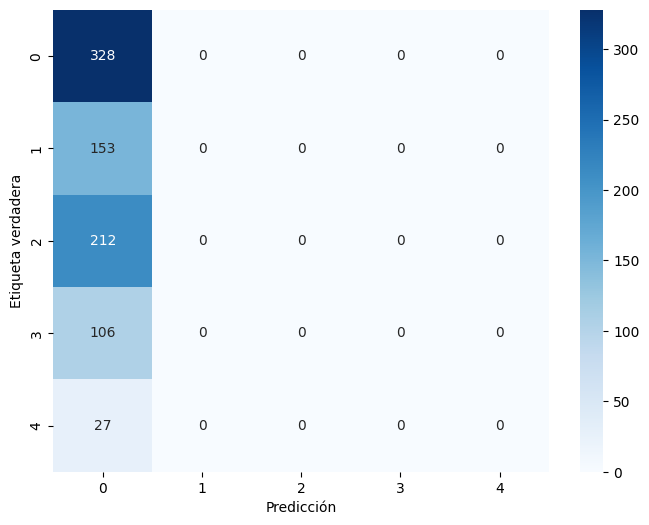

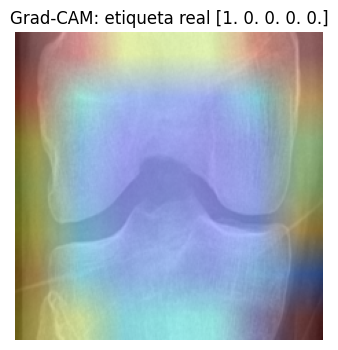

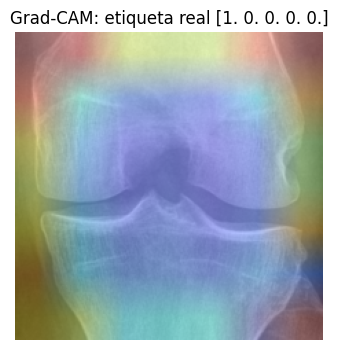

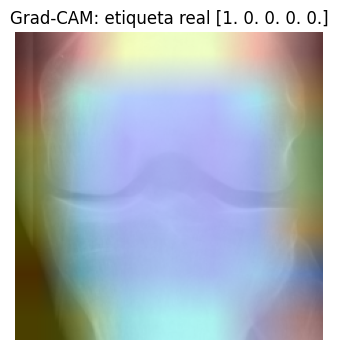

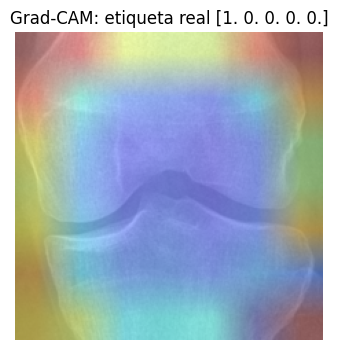

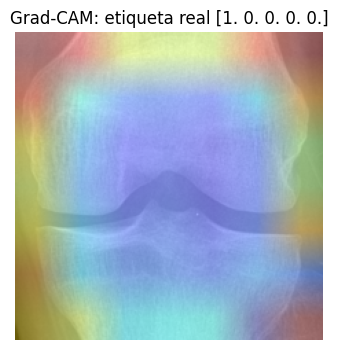

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
              precision    recall  f1-score   support

           0     0.2651    1.0000    0.4190        22
           1     0.0000    0.0000    0.0000        30
           2     0.0000    0.0000    0.0000        18
           3     0.0000    0.0000    0.0000        11
           4     0.0000    0.0000    0.0000         2

    accuracy                         0.2651        83
   macro avg     0.0530    0.2000    0.0838        83
weighted avg     0.0703    0.2651    0.1111        83



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


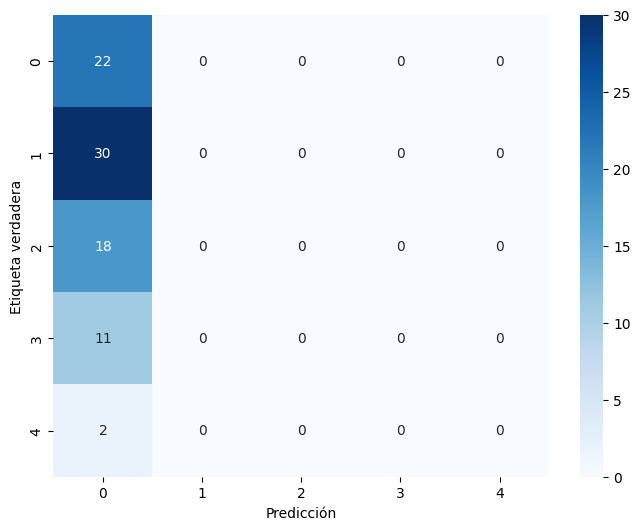

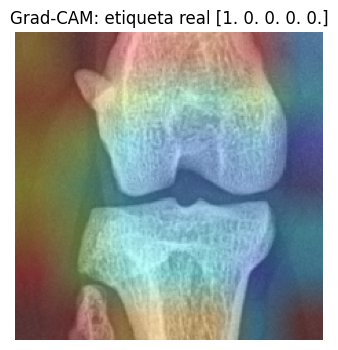

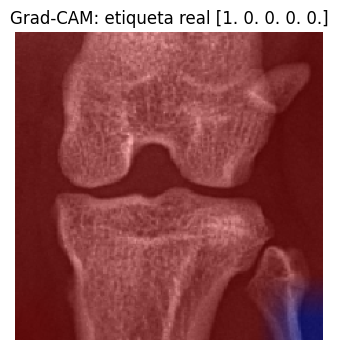

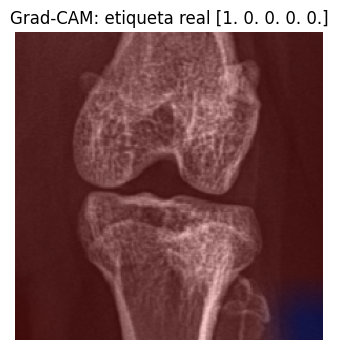

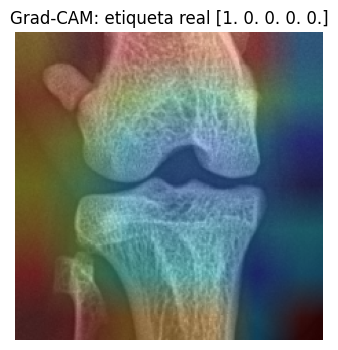

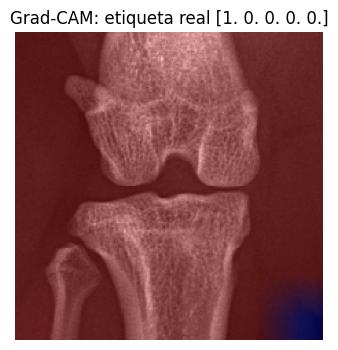

In [12]:
regression = False
tarea = 0
frozen=True
batch_size = 32
num_classes = 5
if regression:
    num_classes = 1
elif tarea == 1:
    num_classes = 3
elif tarea > 1:
    num_classes = 2

loss = 'mean_squared_error' if regression else 'categorical_crossentropy'
metrics = ['mae'] if regression else ['accuracy']

# Generadores de datos (entrenamiento y validación)
train_gen = get_datagen(tarea=tarea, path=train_dir, regression=regression, BATCH_SIZE=batch_size, augment=True)
val_gen   = get_datagen(tarea=tarea, path=val_dir,  BATCH_SIZE=batch_size, regression=regression)
cat_gen = get_datagen(tarea=tarea, path=cat_dir, BATCH_SIZE=batch_size, regression=regression)


model = efficientnetB0_model(num_classes, regression, frozen)
model.compile(optimizer='adam',
                  loss=loss,
                  metrics=metrics)
callbacks=get_callbacks(regression, cat_gen)
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=callbacks
)

model.load_weights('best_model.keras')
# Obtén el diccionario original {etiqueta_str: índice_entero}
evaluate_model(model, regression=regression, generator=val_gen)
model.load_weights('best_model_cat.keras')
evaluate_model(model, regression=regression, generator=cat_gen)

Found 5778 validated image filenames.
Found 826 validated image filenames.
Found 83 validated image filenames.
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - loss: 4.9081 - mae: 1.6780🐾 [Cat Val] MAE: 0.8204 | Accuracy: 0.3614
📦 Modelo mejorado guardado en best_model_cat.keras

Epoch 1: val_loss improved from inf to 1.46258, saving model to best_model.keras
181/181 ━━━━━━━━━━━━━━━━━━━━ 117s 526ms/step - loss: 4.8966 - mae: 1.6760 - val_loss: 1.4626 - val_mae: 1.0091 - learning_rate: 0.0010
Epoch 2/50
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - loss: 2.5035 - mae: 1.2466🐾 [Cat Val] MAE: 0.8359 | Accuracy: 0.3614

Epoch 2: val_loss improved from 1.46258 to 1.43813, saving model to best_model.keras
181/181 ━━━━━━━━━━━━━━━━━━━━ 70s 371ms/step - loss: 2.5016 - mae: 1.2463 - val_loss: 1.4381 - val_mae: 1.0189 - learning_rate: 0.0010
Epoch 3/50
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - loss: 2.0954 - mae: 1.1715🐾 [Cat Val] MAE: 0.8528 | Accuracy: 0.3614

Epoch 3: val_loss improved from 1.43813 to 1.42228, saving model to best_model.keras
181/181 ━━━━━━━━━━━━━━━━━━━━ 69s 367ms/step - loss: 2.0943 - m

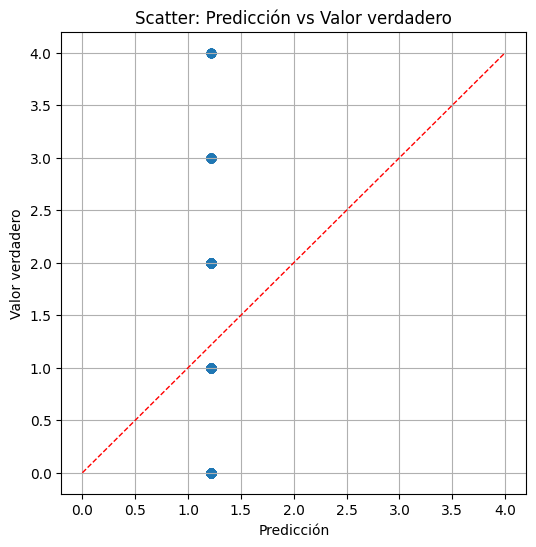

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

        KL 0     0.0000    0.0000    0.0000       328
        KL 1     0.1852    1.0000    0.3126       153
        KL 2     0.0000    0.0000    0.0000       212
        KL 3     0.0000    0.0000    0.0000       106
        KL 4     0.0000    0.0000    0.0000        27

    accuracy                         0.1852       826
   macro avg     0.0370    0.2000    0.0625       826
weighted avg     0.0343    0.1852    0.0579       826



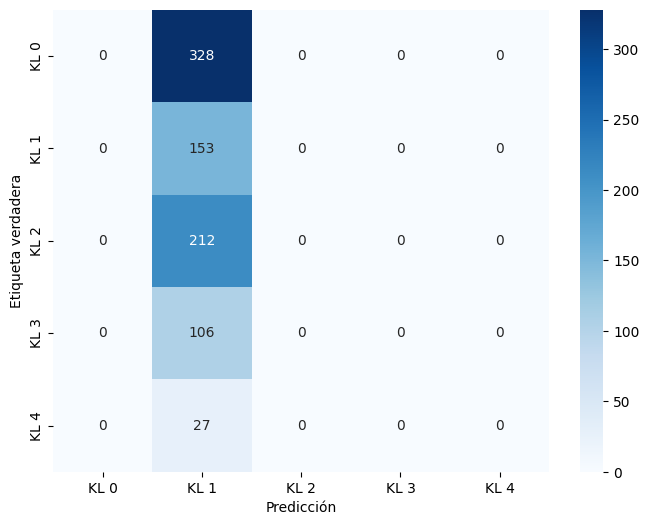

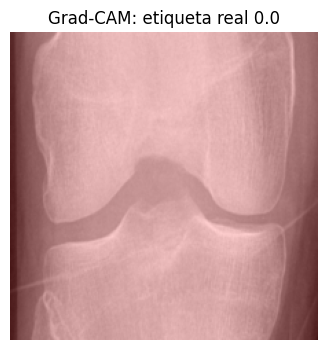

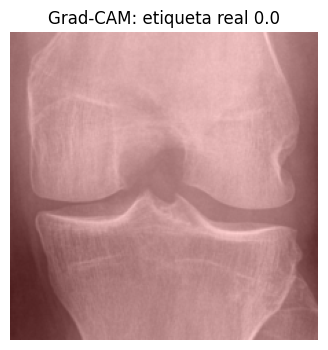

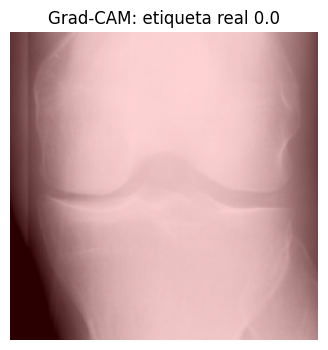

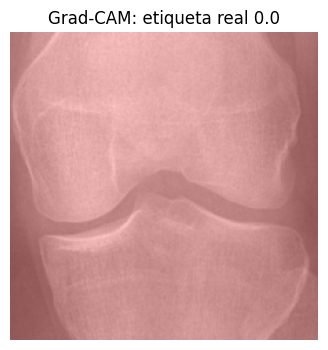

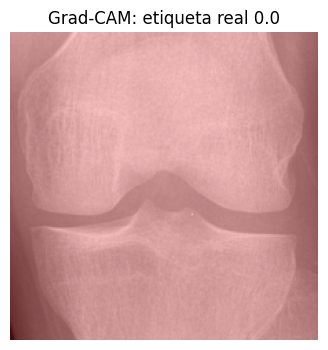

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Mean Absolute Error (MAE): 0.8204



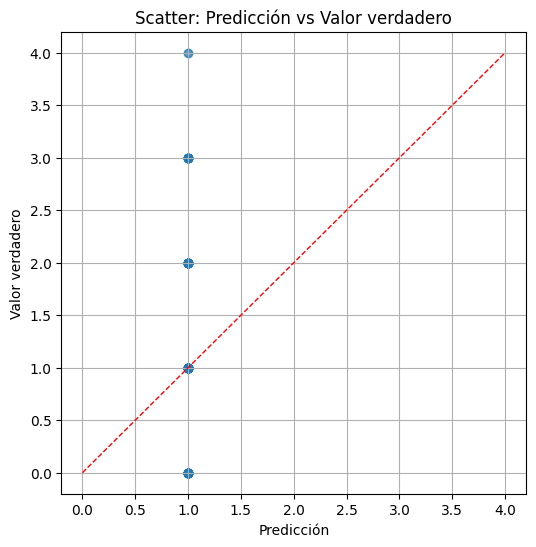

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

        KL 0     0.0000    0.0000    0.0000        22
        KL 1     0.3614    1.0000    0.5310        30
        KL 2     0.0000    0.0000    0.0000        18
        KL 3     0.0000    0.0000    0.0000        11
        KL 4     0.0000    0.0000    0.0000         2

    accuracy                         0.3614        83
   macro avg     0.0723    0.2000    0.1062        83
weighted avg     0.1306    0.3614    0.1919        83



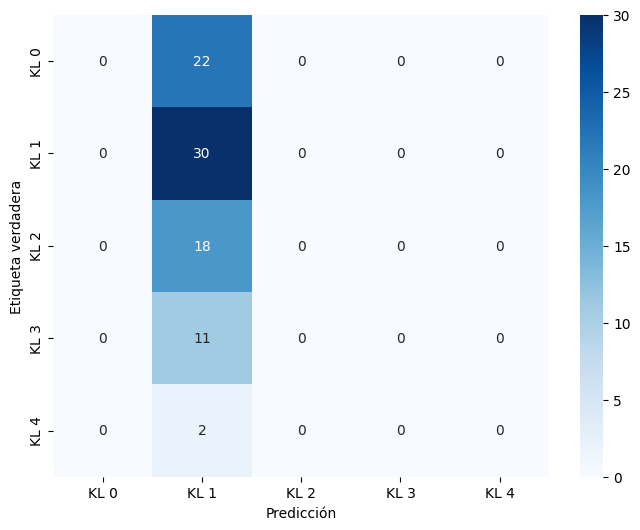

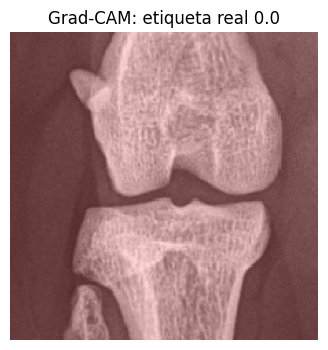

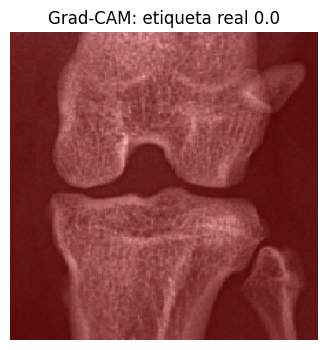

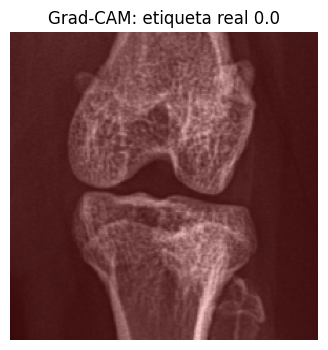

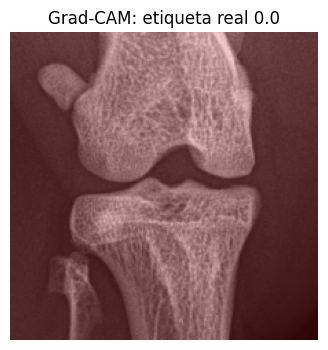

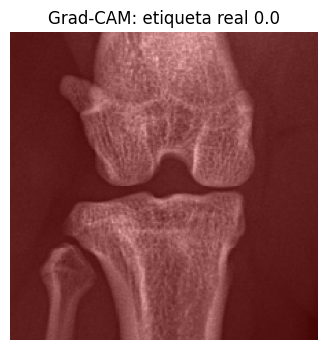

In [13]:
regression = True
tarea = 0
frozen=True
batch_size = 32
num_classes = 5
if regression:
    num_classes = 1
elif tarea == 1:
    num_classes = 3
elif tarea > 1:
    num_classes = 2

loss = 'mean_squared_error' if regression else 'categorical_crossentropy'
metrics = ['mae'] if regression else ['accuracy']

# Generadores de datos (entrenamiento y validación)
train_gen = get_datagen(tarea=tarea, path=train_dir, regression=regression, BATCH_SIZE=batch_size, augment=True)
val_gen   = get_datagen(tarea=tarea, path=val_dir,  BATCH_SIZE=batch_size, regression=regression)
cat_gen = get_datagen(tarea=tarea, path=cat_dir, BATCH_SIZE=batch_size, regression=regression)


model = efficientnetB0_model(num_classes, regression, frozen)
model.compile(optimizer='adam',
                  loss=loss,
                  metrics=metrics)
callbacks=get_callbacks(regression, cat_gen)
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=callbacks
)

model.load_weights('best_model.keras')
# Obtén el diccionario original {etiqueta_str: índice_entero}
evaluate_model(model, regression=regression, generator=val_gen)
model.load_weights('best_model_cat.keras')
evaluate_model(model, regression=regression, generator=cat_gen)

Found 5778 validated image filenames belonging to 3 classes.
Found 826 validated image filenames belonging to 3 classes.
Found 83 validated image filenames belonging to 3 classes.
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - accuracy: 0.4678 - loss: 1.3556🐾 [Cat Val] Loss: 0.5402 | Accuracy: 0.8434
📦 Modelo mejorado guardado en best_model_cat.keras

Epoch 1: val_accuracy improved from -inf to 0.83898, saving model to best_model.keras
181/181 ━━━━━━━━━━━━━━━━━━━━ 124s 555ms/step - accuracy: 0.4693 - loss: 1.3522 - val_accuracy: 0.8390 - val_loss: 0.5531 - learning_rate: 0.0010
Epoch 2/50
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.7889 - loss: 0.6894🐾 [Cat Val] Loss: 0.5103 | Accuracy: 0.8434
📦 Modelo mejorado guardado en best_model_cat.keras

Epoch 2: val_accuracy did not improve from 0.83898
181/181 ━━━━━━━━━━━━━━━━━━━━ 69s 367ms/step - accuracy: 0.7890 - loss: 0.6892 - val_accuracy: 0.8390 - val_loss: 0.5275 - learning_rate: 0.0010
Epoch 3/50
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.8193 - loss: 0.6238🐾 [Cat Val] Loss: 0.5018 | Accuracy: 0.8434
📦 Modelo mejorado guardado en best_model_cat.keras

Epoch 3: val_accuracy did not improv

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


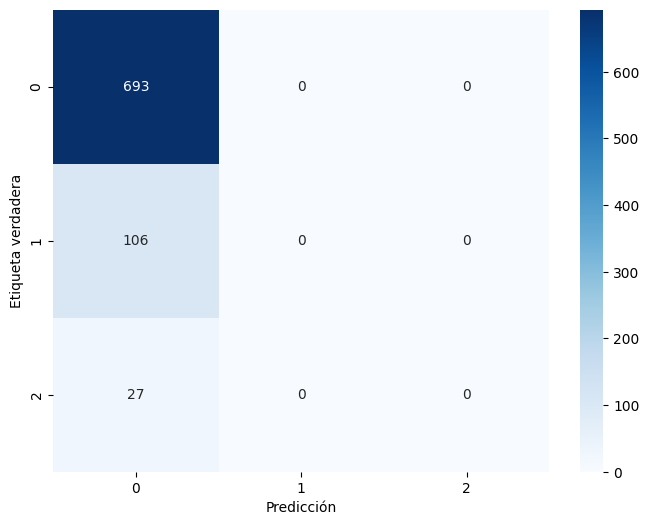

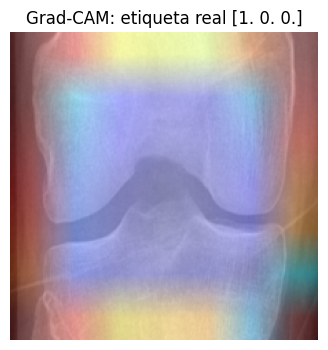

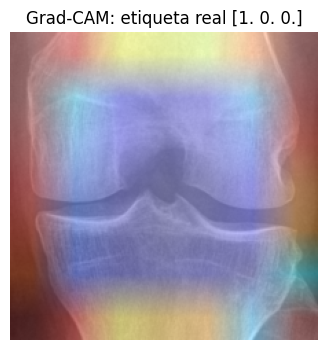

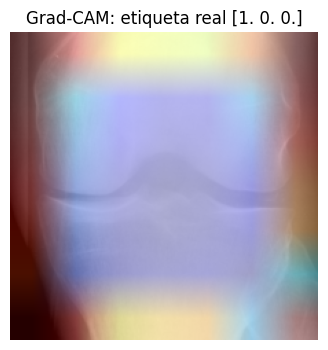

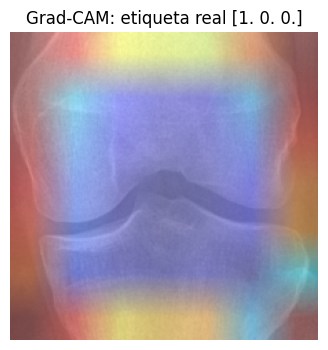

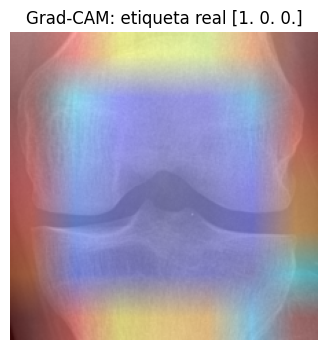

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
              precision    recall  f1-score   support

           0     0.8434    1.0000    0.9150        70
           1     0.0000    0.0000    0.0000        11
           2     0.0000    0.0000    0.0000         2

    accuracy                         0.8434        83
   macro avg     0.2811    0.3333    0.3050        83
weighted avg     0.7113    0.8434    0.7717        83



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


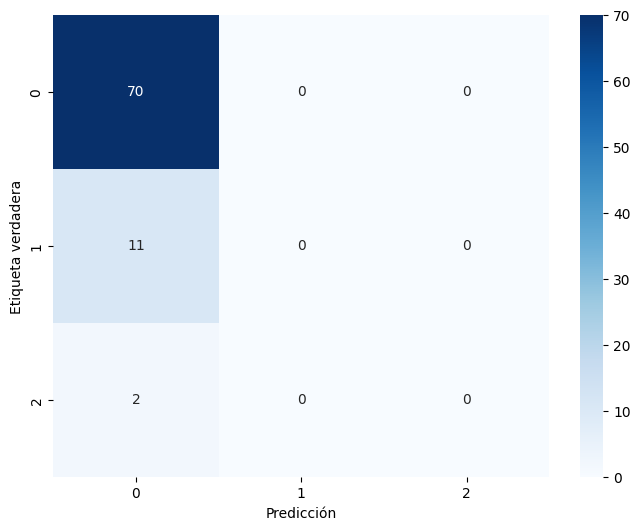

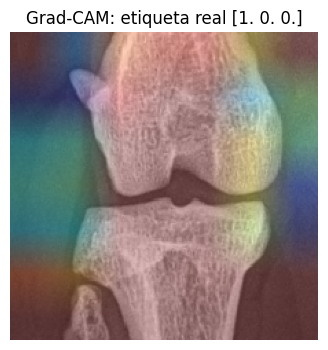

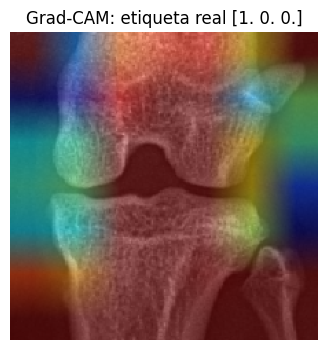

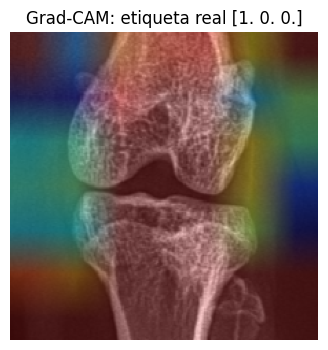

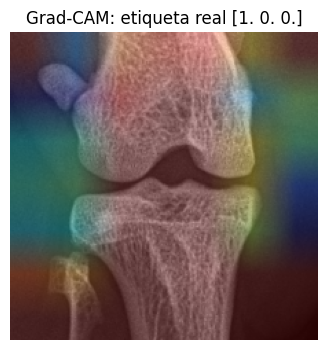

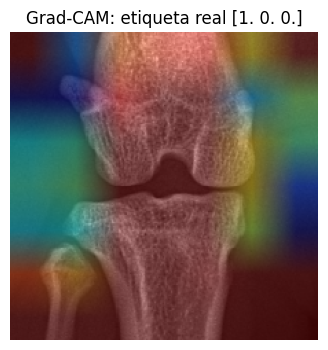

In [14]:
regression = False
tarea = 1
frozen=True
batch_size = 32
num_classes = 5
if regression:
    num_classes = 1
elif tarea == 1:
    num_classes = 3
elif tarea > 1:
    num_classes = 2

loss = 'mean_squared_error' if regression else 'categorical_crossentropy'
metrics = ['mae'] if regression else ['accuracy']

# Generadores de datos (entrenamiento y validación)
train_gen = get_datagen(tarea=tarea, path=train_dir, regression=regression, BATCH_SIZE=batch_size, augment=True)
val_gen   = get_datagen(tarea=tarea, path=val_dir,  BATCH_SIZE=batch_size, regression=regression)
cat_gen = get_datagen(tarea=tarea, path=cat_dir, BATCH_SIZE=batch_size, regression=regression)


model = efficientnetB0_model(num_classes, regression, frozen)
model.compile(optimizer='adam',
                  loss=loss,
                  metrics=metrics)
callbacks=get_callbacks(regression, cat_gen)
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=callbacks
)

model.load_weights('best_model.keras')
# Obtén el diccionario original {etiqueta_str: índice_entero}
evaluate_model(model, regression=regression, generator=val_gen)
model.load_weights('best_model_cat.keras')
evaluate_model(model, regression=regression, generator=cat_gen)

Found 5778 validated image filenames.
Found 826 validated image filenames.
Found 83 validated image filenames.
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - loss: 2.7685 - mae: 1.1925🐾 [Cat Val] MAE: 0.2362 | Accuracy: 0.8434
📦 Modelo mejorado guardado en best_model_cat.keras

Epoch 1: val_loss improved from inf to 0.23434, saving model to best_model.keras
181/181 ━━━━━━━━━━━━━━━━━━━━ 111s 500ms/step - loss: 2.7609 - mae: 1.1905 - val_loss: 0.2343 - val_mae: 0.2484 - learning_rate: 0.0010
Epoch 2/50
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - loss: 1.1253 - mae: 0.7404🐾 [Cat Val] MAE: 0.2952 | Accuracy: 0.8434

Epoch 2: val_loss improved from 0.23434 to 0.22232, saving model to best_model.keras
181/181 ━━━━━━━━━━━━━━━━━━━━ 70s 371ms/step - loss: 1.1237 - mae: 0.7398 - val_loss: 0.2223 - val_mae: 0.3064 - learning_rate: 0.0010
Epoch 3/50
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - loss: 0.6931 - mae: 0.5705🐾 [Cat Val] MAE: 0.3307 | Accuracy: 0.8434

Epoch 3: val_loss improved from 0.22232 to 0.22217, saving model to best_model.keras
181/181 ━━━━━━━━━━━━━━━━━━━━ 71s 376ms/step - loss: 0.6926 - m

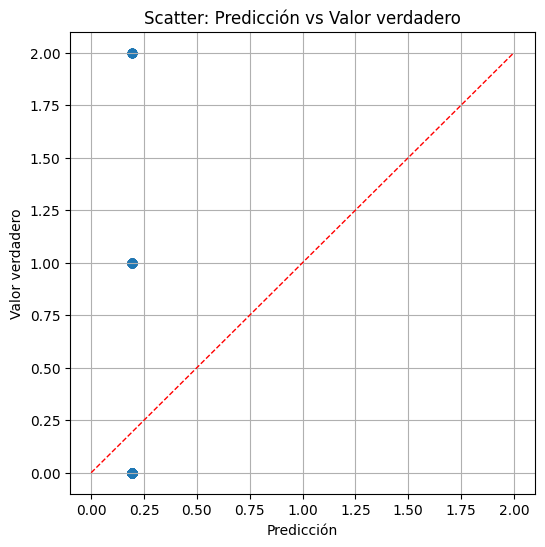

              precision    recall  f1-score   support

        KL 0     0.8390    1.0000    0.9124       693
        KL 1     0.0000    0.0000    0.0000       106
        KL 2     0.0000    0.0000    0.0000        27

    accuracy                         0.8390       826
   macro avg     0.2797    0.3333    0.3041       826
weighted avg     0.7039    0.8390    0.7655       826



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


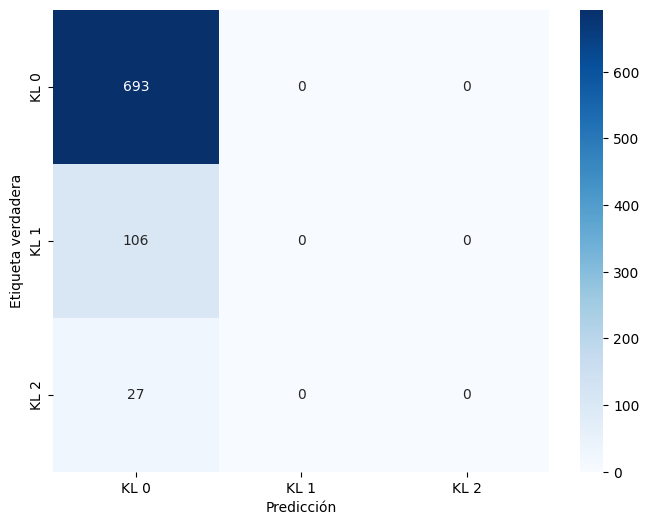

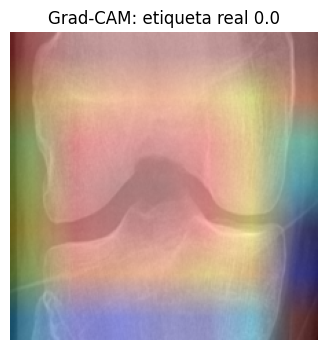

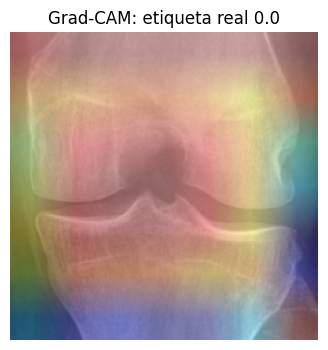

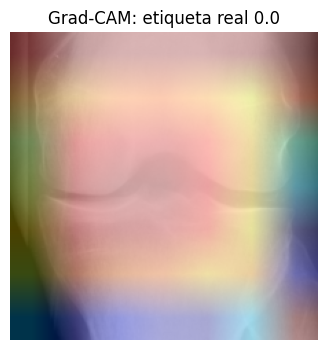

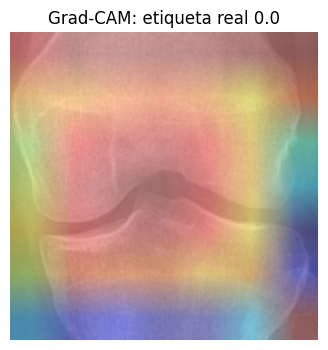

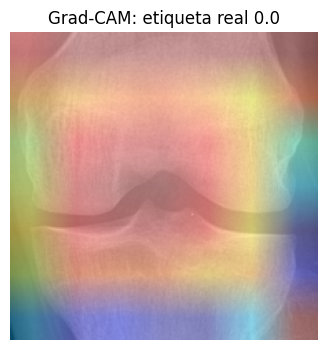

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step 
Mean Absolute Error (MAE): 0.2362



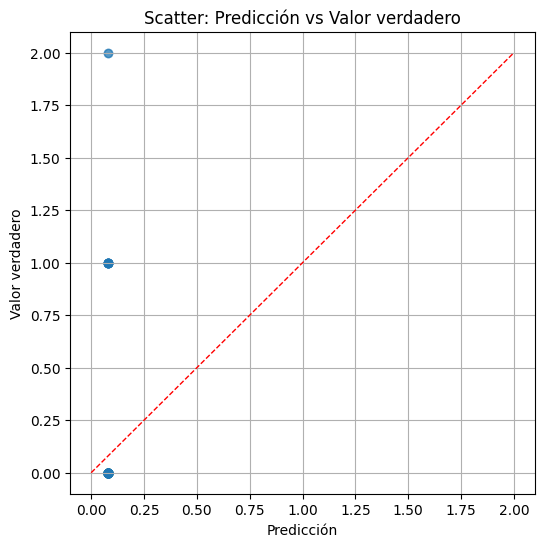

              precision    recall  f1-score   support

        KL 0     0.8434    1.0000    0.9150        70
        KL 1     0.0000    0.0000    0.0000        11
        KL 2     0.0000    0.0000    0.0000         2

    accuracy                         0.8434        83
   macro avg     0.2811    0.3333    0.3050        83
weighted avg     0.7113    0.8434    0.7717        83



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


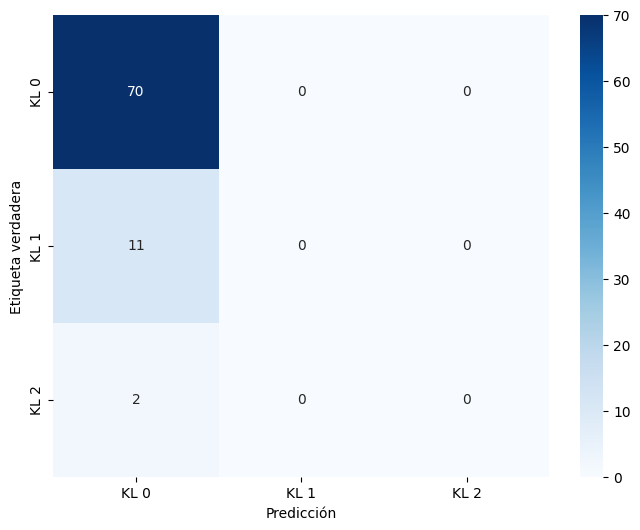

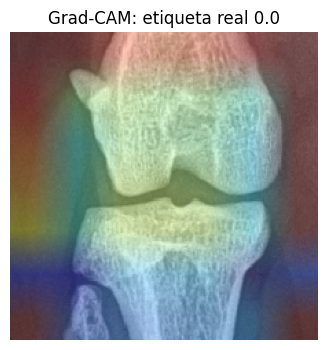

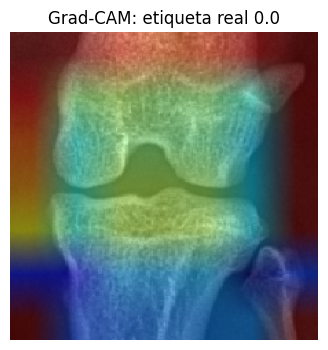

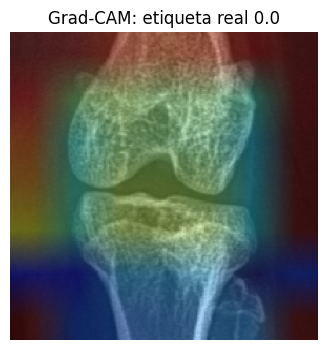

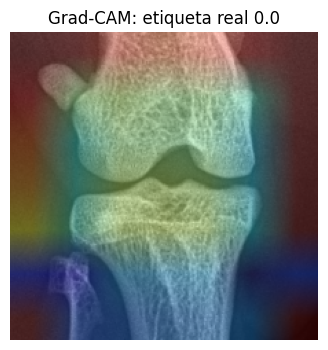

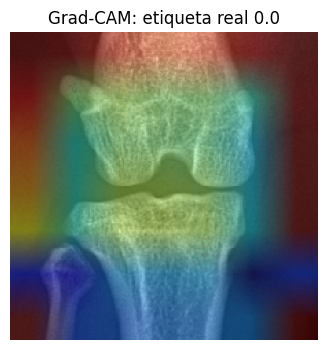

In [15]:
regression = True
tarea = 1
frozen=True
batch_size = 32
num_classes = 5
if regression:
    num_classes = 1
elif tarea == 1:
    num_classes = 3
elif tarea > 1:
    num_classes = 2

loss = 'mean_squared_error' if regression else 'categorical_crossentropy'
metrics = ['mae'] if regression else ['accuracy']

# Generadores de datos (entrenamiento y validación)
train_gen = get_datagen(tarea=tarea, path=train_dir, regression=regression, BATCH_SIZE=batch_size, augment=True)
val_gen   = get_datagen(tarea=tarea, path=val_dir,  BATCH_SIZE=batch_size, regression=regression)
cat_gen = get_datagen(tarea=tarea, path=cat_dir, BATCH_SIZE=batch_size, regression=regression)


model = efficientnetB0_model(num_classes, regression, frozen)
model.compile(optimizer='adam',
                  loss=loss,
                  metrics=metrics)
callbacks=get_callbacks(regression, cat_gen)
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=callbacks
)

model.load_weights('best_model.keras')
# Obtén el diccionario original {etiqueta_str: índice_entero}
evaluate_model(model, regression=regression, generator=val_gen)
model.load_weights('best_model_cat.keras')
evaluate_model(model, regression=regression, generator=cat_gen)

Found 3332 validated image filenames belonging to 2 classes.
Found 481 validated image filenames belonging to 2 classes.
Found 52 validated image filenames belonging to 2 classes.
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.5228 - loss: 1.1566🐾 [Cat Val] Loss: 0.8806 | Accuracy: 0.4231
📦 Modelo mejorado guardado en best_model_cat.keras

Epoch 1: val_accuracy improved from -inf to 0.68191, saving model to best_model.keras
105/105 ━━━━━━━━━━━━━━━━━━━━ 93s 687ms/step - accuracy: 0.5237 - loss: 1.1541 - val_accuracy: 0.6819 - val_loss: 0.6299 - learning_rate: 0.0010
Epoch 2/50
104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.6067 - loss: 0.8567🐾 [Cat Val] Loss: 0.8718 | Accuracy: 0.4231
📦 Modelo mejorado guardado en best_model_cat.keras

Epoch 2: val_accuracy did not improve from 0.68191
105/105 ━━━━━━━━━━━━━━━━━━━━ 39s 350ms/step - accuracy: 0.6067 - loss: 0.8561 - val_accuracy: 0.6819 - val_loss: 0.6288 - learning_rate: 0.0010
Epoch 3/50
104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.6131 - loss: 0.7886🐾 [Cat Val] Loss: 0.8182 | Accuracy: 0.4231
📦 Modelo mejorado guardado en best_model_cat.keras

Epoch 3: val_accuracy did not improve

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


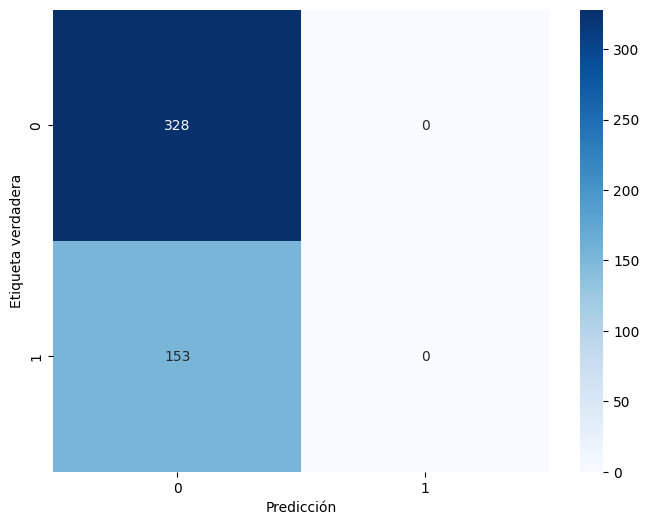

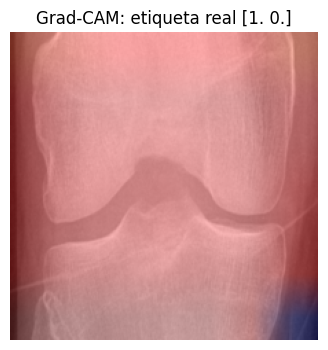

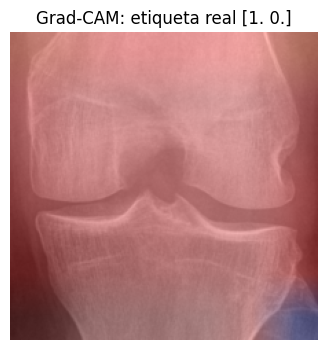

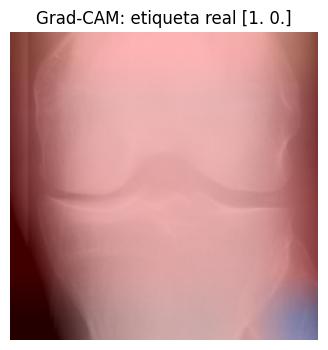

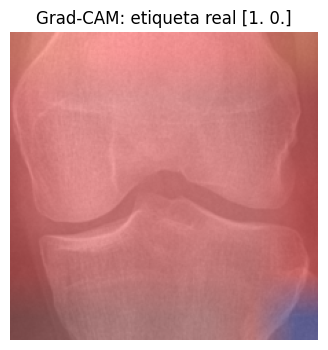

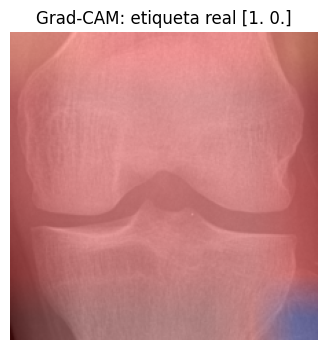

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
              precision    recall  f1-score   support

           0     0.4231    1.0000    0.5946        22
           1     0.0000    0.0000    0.0000        30

    accuracy                         0.4231        52
   macro avg     0.2115    0.5000    0.2973        52
weighted avg     0.1790    0.4231    0.2516        52



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


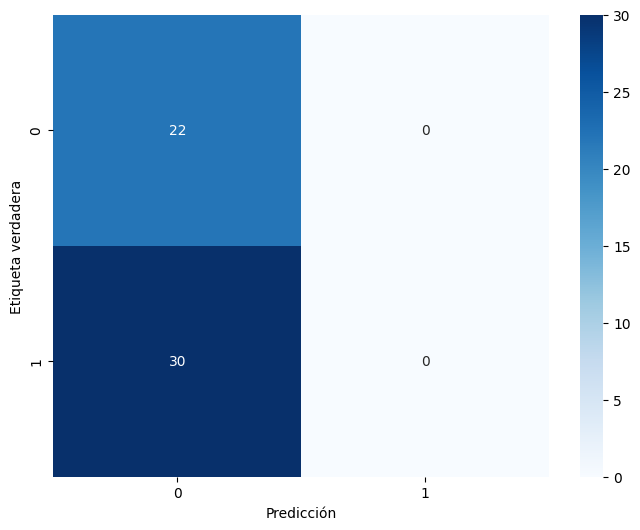

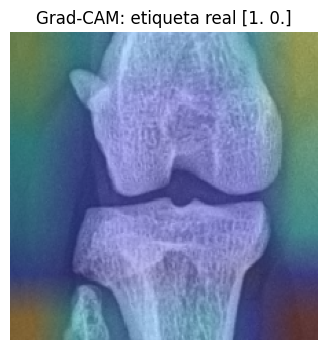

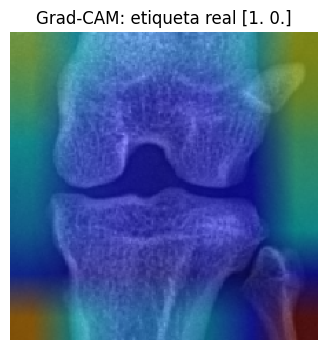

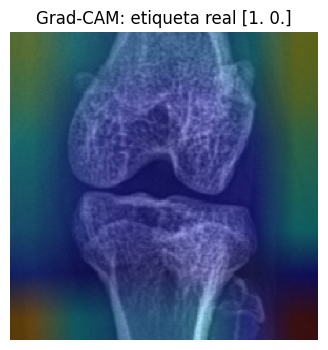

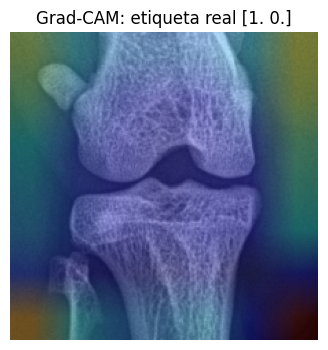

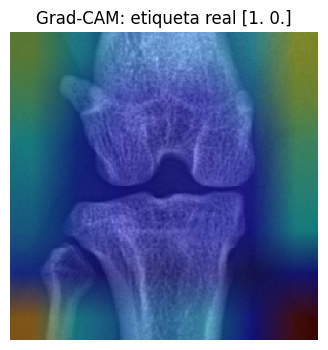

In [16]:
regression = False
tarea = 2
frozen=True
batch_size = 32
num_classes = 5
if regression:
    num_classes = 1
elif tarea == 1:
    num_classes = 3
elif tarea > 1:
    num_classes = 2

loss = 'mean_squared_error' if regression else 'categorical_crossentropy'
metrics = ['mae'] if regression else ['accuracy']

# Generadores de datos (entrenamiento y validación)
train_gen = get_datagen(tarea=tarea, path=train_dir, regression=regression, BATCH_SIZE=batch_size, augment=True)
val_gen   = get_datagen(tarea=tarea, path=val_dir,  BATCH_SIZE=batch_size, regression=regression)
cat_gen = get_datagen(tarea=tarea, path=cat_dir, BATCH_SIZE=batch_size, regression=regression)


model = efficientnetB0_model(num_classes, regression, frozen)
model.compile(optimizer='adam',
                  loss=loss,
                  metrics=metrics)
callbacks=get_callbacks(regression, cat_gen)
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=callbacks
)

model.load_weights('best_model.keras')
# Obtén el diccionario original {etiqueta_str: índice_entero}
evaluate_model(model, regression=regression, generator=val_gen)
model.load_weights('best_model_cat.keras')
evaluate_model(model, regression=regression, generator=cat_gen)

Found 3802 validated image filenames belonging to 2 classes.
Found 540 validated image filenames belonging to 2 classes.
Found 40 validated image filenames belonging to 2 classes.
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


118/119 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.5013 - loss: 1.1313🐾 [Cat Val] Loss: 0.7041 | Accuracy: 0.5500
📦 Modelo mejorado guardado en best_model_cat.keras

Epoch 1: val_accuracy improved from -inf to 0.60741, saving model to best_model.keras
119/119 ━━━━━━━━━━━━━━━━━━━━ 107s 713ms/step - accuracy: 0.5015 - loss: 1.1295 - val_accuracy: 0.6074 - val_loss: 0.6718 - learning_rate: 0.0010
Epoch 2/50
118/119 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.5166 - loss: 0.8883🐾 [Cat Val] Loss: 0.6889 | Accuracy: 0.5500
📦 Modelo mejorado guardado en best_model_cat.keras

Epoch 2: val_accuracy did not improve from 0.60741
119/119 ━━━━━━━━━━━━━━━━━━━━ 50s 399ms/step - accuracy: 0.5168 - loss: 0.8876 - val_accuracy: 0.6074 - val_loss: 0.6730 - learning_rate: 0.0010
Epoch 3/50
118/119 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.5582 - loss: 0.7812🐾 [Cat Val] Loss: 0.7242 | Accuracy: 0.5500

Epoch 3: val_accuracy did not improve from 0.60741
119/119 ━━━━━━━━━━━━━━━━━━━━ 49s 392

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


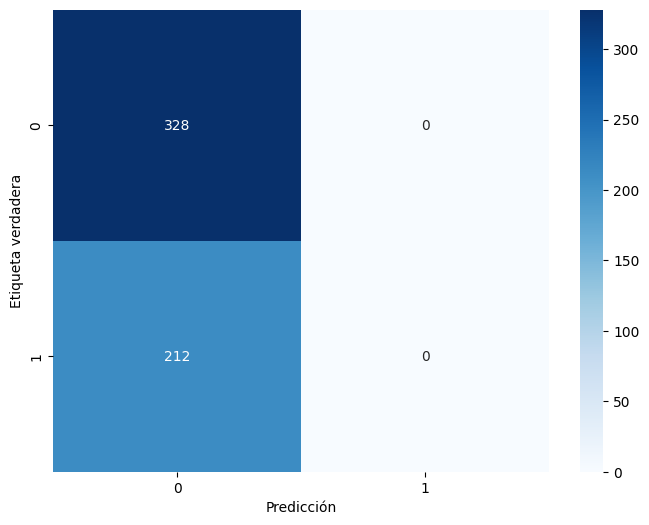

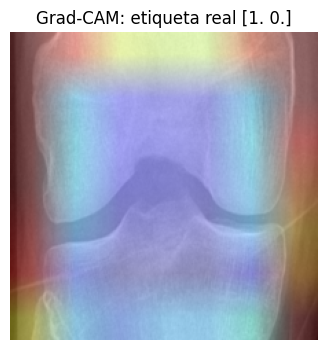

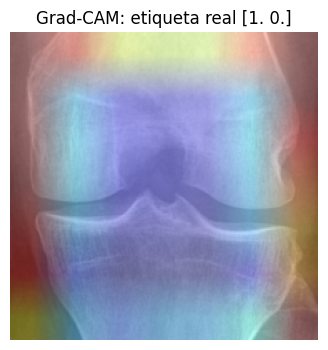

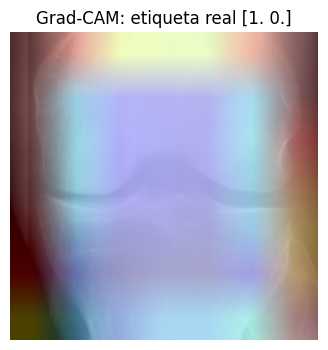

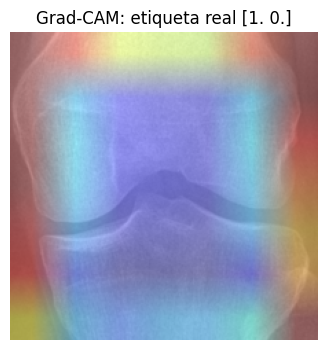

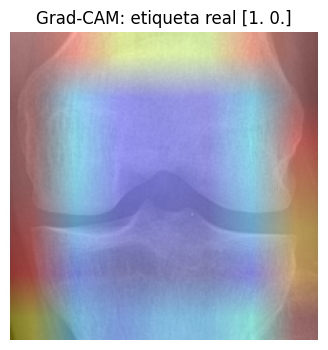

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step 
              precision    recall  f1-score   support

           0     0.5500    1.0000    0.7097        22
           1     0.0000    0.0000    0.0000        18

    accuracy                         0.5500        40
   macro avg     0.2750    0.5000    0.3548        40
weighted avg     0.3025    0.5500    0.3903        40



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


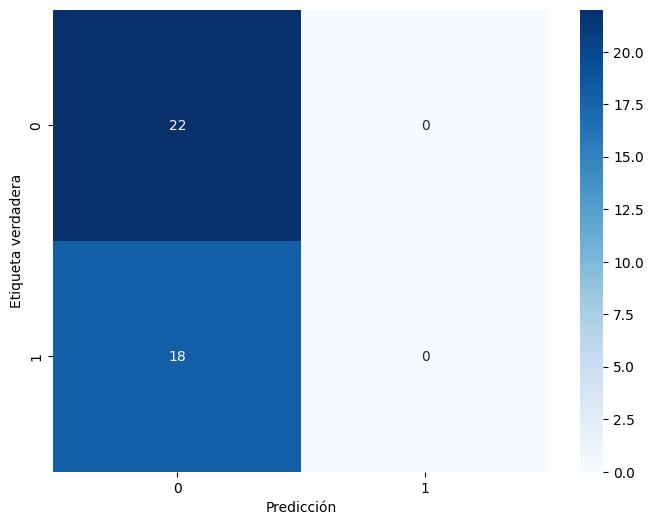

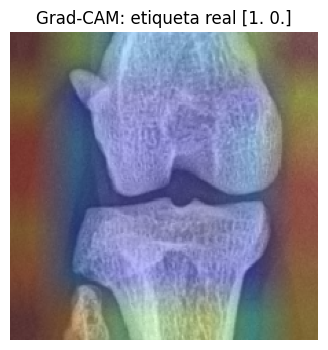

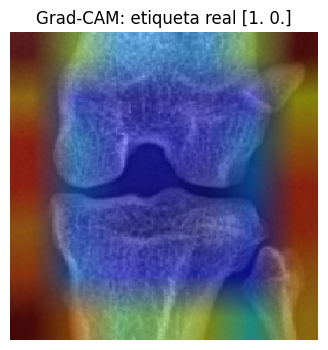

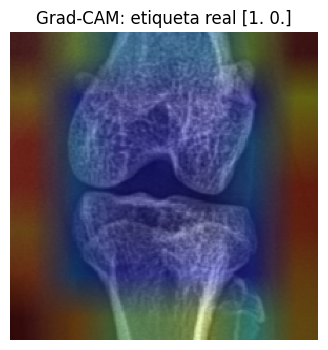

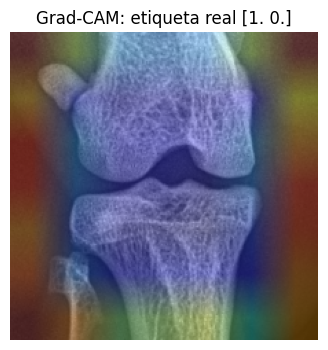

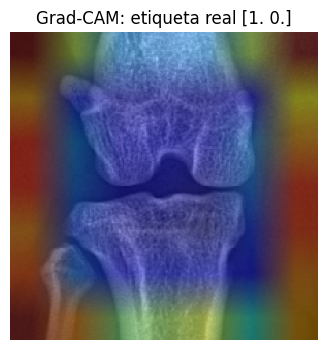

In [17]:
regression = False
tarea = 3
frozen=True
batch_size = 32
num_classes = 5
if regression:
    num_classes = 1
elif tarea == 1:
    num_classes = 3
elif tarea > 1:
    num_classes = 2

loss = 'mean_squared_error' if regression else 'categorical_crossentropy'
metrics = ['mae'] if regression else ['accuracy']

# Generadores de datos (entrenamiento y validación)
train_gen = get_datagen(tarea=tarea, path=train_dir, regression=regression, BATCH_SIZE=batch_size, augment=True)
val_gen   = get_datagen(tarea=tarea, path=val_dir,  BATCH_SIZE=batch_size, regression=regression)
cat_gen = get_datagen(tarea=tarea, path=cat_dir, BATCH_SIZE=batch_size, regression=regression)


model = efficientnetB0_model(num_classes, regression, frozen)
model.compile(optimizer='adam',
                  loss=loss,
                  metrics=metrics)
callbacks=get_callbacks(regression, cat_gen)
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=callbacks
)

model.load_weights('best_model.keras')
# Obtén el diccionario original {etiqueta_str: índice_entero}
evaluate_model(model, regression=regression, generator=val_gen)
model.load_weights('best_model_cat.keras')
evaluate_model(model, regression=regression, generator=cat_gen)

# Anterior

## Exploración del dataset de artrosis de rodilla

- **Total de imágenes:** 9 786

| Partición      | Imágenes | Porcentaje |
|---------------|---------:|-----------:|
| **Train**      | 5 778    | 59.04 %    |
| **Validation** |   826    |  8.44 %    |
| **Test**       | 1 656    | 16.92 %    |
| **AutoTest**   | 1 526    | 15.59 %    |


### Distribución de clases en `Train`

|  Clase  | Índice | Imágenes | Porcentaje |
|---------|-------:|---------:|-----------:|
| Sin     |      0 |    2 286 |     39.56 % |
| Ligera  |      1 |    1 046 |     18.10 % |
| Leve    |      2 |    1 516 |     26.24 % |
| Moderada|      3 |      757 |     13.10 % |
| Severa  |      4 |      173 |      2.99 % |

